In [1]:
import gensim
import subprocess
import re
import numpy as np
import time
import nltk
import os
import json
import collections
import time
import matplotlib.pyplot as plt
import itertools
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
nltk.download('stopwords')
nltk.download('punkt')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Problema: Determinar la veracidad de tweets, utilizando clasificación
- Implementar un clasificador de post de tweets para validar su veracidad.
- Para esto se utilizará redes neuronales y el árbol de  propagación de los tweets.


In [2]:
#Image("/home/eprovidel/Text_Mining/Proyecto/modelos.png")

In [3]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

# Parte 1: Procesamiento de datos y funcionalidades

## Parte 1.1: Cargar tweets para generar datos de entrenamiento

In [4]:
words_not_in_model = list()
def computeDocumentAWE(docText, _model, _model_vocab, _emb_size):
    """
    Calcula el AWE del texto recibido en el parámetro docText.
    La variable docSum almacena la suma de los embeddings de cada
    palabra w en docText. Luego esta suma se divide por el total
    de n palabras consideradas.
    
    Se considero una palabra para el cálculo sólo si esta pertenece
    al vocabulario del modelo. Si no, no es considerada en la suma 
    ni tampoco en el calculo de n.
    """    
    docSum = np.zeros(_emb_size)
    n = 0
    
    ####
    ## AWE = 1/n * Sum w_embedding, para cada w en docText
    ####
    
    normalizedDocText = normalizarTexto(docText)
    
    for w in normalizedDocText:
        ## Se descartan palabras que no están en el modelo de embeddings (vocabulario)
        if w in _model_vocab:
            n = n + 1
            w_embedding = _model[w]
            docSum = docSum + w_embedding
        else:
            words_not_in_model.append(w)

    return docSum / n if n > 0 else docSum    

In [5]:
def normalizarTexto(docText):
    # En gensim.utils, pasa a minúsculas, descarta palabras muy grandes o muy pequeñas.
    return simple_preprocess(docText)

In [6]:
def parseTwitterTree(tree_file):
    tree_data = list()
    for line in tree_file:
        _, second_part = line.split('->')
        second_part = second_part.rstrip()
        second_part = second_part.replace("'", "\"")
        tree_data.append(json.loads(second_part))     
    return tree_data

In [7]:
### Obtener diccionario con todos los posts
all_posts = {}
all_text = {}
#for file in os.listdir('/home/kirov/dataset/post'):
for file in os.listdir('./post'):    
    if file.endswith(".json"):        
        try:        
            with open(os.path.join('./post', file), 'r') as f:
                tweet_id  = os.path.splitext(file)[0]
                tweet_dic = json.load(f)
                all_posts[tweet_id] = tweet_dic
                

        except:
            pass
        

### Obtener ids de tweets etiquetados
labels = {}
with open('label.txt') as label_f:
    for label_line in label_f:
        
        label, tweet_id = label_line.split(':')
        tweet_id = tweet_id.rstrip()
        labels[tweet_id] = label

print("Tweets etiquetados      : ", len(labels))        

seqs_lens = []
labeled_posts = {}
number_of_tweets = 0
number_of_retweets = 0
number_of_invalid_tweets = 0
no_in_data = 0
for tweet_id in labels.keys():
    try:
        if tweet_id in all_posts:
            tree_path = os.path.join('./tree', tweet_id + '.txt')
            with open(tree_path) as tree_file:
                tree_data = parseTwitterTree(tree_file)
                ### Remover retweets                
                first = tree_data[0]
                without_rt = list(filter(lambda t: t[1] != tweet_id, tree_data))
                number_of_retweets = number_of_retweets + (len(tree_data) - len(without_rt))
                only_valid = list(filter(lambda t: t[1] in all_posts, without_rt))
                number_of_invalid_tweets = number_of_invalid_tweets + (len(without_rt) - len(only_valid))
                seqs_lens.append(len(only_valid))
                labeled_posts[tweet_id] = (labels[tweet_id], [first] + only_valid)
                number_of_tweets = number_of_tweets + 1 
        else:
             no_in_data = no_in_data + 1 
        
    except Exception as e:
        print(e)             
        
        
print("no_in_data              : ", no_in_data) ## están etiquetados, pero no en los post
print("number_of_tweets        : ", number_of_tweets)        
print("all_posts               : ", len(all_posts))
print("number_of_retweets      : ", number_of_retweets) ## En árbol de propagación
print("number_of_invalid_tweets: ", number_of_invalid_tweets) ## En árbol de propagación


Tweets etiquetados      :  818
no_in_data              :  65
number_of_tweets        :  753
all_posts               :  21741
number_of_retweets      :  297301
number_of_invalid_tweets:  6432


**Importante:** Importan sólo los datos etiquetados que se conocen y que no son retweets de cada árbol de progación.

## Parte 1.2: Aplicar AWE a cada tweet del arbol

In [10]:
## Cada palabra tiene un embedding que viene del modelo
## Se calcula AWE para cada post del árbol de propagación (lista de propagación que el primer elemento es el tweet original)
def computeTreeAWE(tree, _model, _model_vocab, _emb_size):
    return list(map(lambda t: [t[0], computeDocumentAWE(all_posts[t[1]]['text'],
                                                        _model, _model_vocab, _emb_size), t[2]], tree))

[17 19 33 23 28 32 22 22 22 22 16 17 15 18 22 15 19 16 21 11  9  8 10 14
  7  9  6  7  8  7 11  6  7  5  5 10  2  3  5  5  1  7  3  7  3  1  3  7
  4  5  2  3  5  1  1  4  1  4  5  0  3  0  1  4  2  3  4  2  1  2  1  1
  4  2  2  4  1  1  5  1  2  2  1  1  1  3  3  0  3  1  1  2  1  2  2  0
  1  1  1  1  0  0  1  0  1  1  0  1  2  1  1  0  0  1  0  1  0  1  0  0
  0  1  1  1  2  0  0  1  0  2  1  1  0  0  1  1  0  0  1  0  0  0  0  0
  1  0  1  0  1  0  0  0  0  0  1  1  0  0  2  1  0  0  1  1  1  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0
  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  1
  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

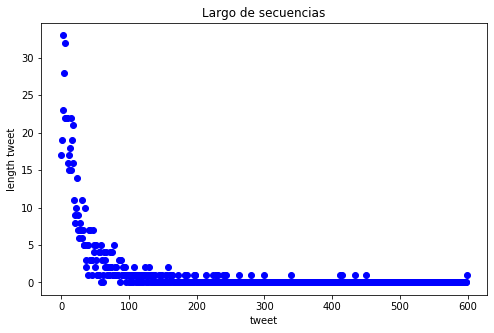

In [11]:
# Categorias: true, false, unverified, non-rumor
categories = ['true', 'false', 'unverified', 'non-rumor']
num_categories = len(categories)

#entrega un vector one-hot de la categoria, de largo 4 (por el número de categorias)
def to_category_vector(category):
    vector = np.zeros(len(categories)).astype(np.float32)
    
    for i in range(len(categories)):
        if categories[i] == category:
            vector[i] = 1.0
            break
    
    return vector

#La red neuronal necesita un tamaño fijo para la secuencia (datos de entrada)
#¿Que largo de secuencia utilizar?
counts = np.bincount(seqs_lens) ## seqs_len sólo de los 753
print(counts)
mode_seq_len = np.argmax(counts)
mean_seq_len = int(np.mean(seqs_lens))
min__seq_len = min(seqs_lens)
max__seq_len = max(seqs_lens) 
## luego se hace padding

print("seqs_lens   : ", seqs_lens)
print("min__seq_len: ", min__seq_len)
print("max__seq_len: ", max__seq_len)
print("mean_seq_len: ", mean_seq_len)
print("mode_seq_len: ", mode_seq_len )

plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(counts,'bo')
plt.title("Largo de secuencias")
plt.xlabel("tweet")
plt.ylabel("length tweet")
plt.savefig('/home/kirov/plots/plt_largoSecuenciasGRU')

tree_max_num_seq = mean_seq_len

In [12]:
## padding al final, con empty
def padAWE(empty, max_num, seq):
    from itertools import repeat
    seq.extend(repeat(empty, max_num - len(seq)))
    return seq

In [13]:
## 
def generate_w2v_variant(_model, _model_vocab, _emb_size):
    
    empty_awe = np.zeros(_emb_size)
    ## Calcula AWE de cada árbol
    labeled_posts_awe = { k: (v[0], computeTreeAWE(v[1], _model, _model_vocab, _emb_size)) for k, v in labeled_posts.items() }
    ## Realiza padding a las secuencias
    padded_labeled_posts_awe = {k: (v[0], padAWE(empty_awe, tree_max_num_seq, v[1])) for k, v in labeled_posts_awe.items()}

    #Genera los datos X e Y para alimentar el modelo de red neuronal
    #Inicialmente con ceros y con la forma adecuada.
    X = np.zeros(shape=(number_of_tweets, tree_max_num_seq, _emb_size)).astype(np.float32)
    Y = np.zeros(shape=(number_of_tweets, num_categories)).astype(np.float32)

    # Asigna al vector X los datos correspondientes
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        for jdx, tweet_d in enumerate(tweet_data[1]):
            ### tweet_d = [uid, tweet_awe, time]
            if jdx == tree_max_num_seq:
                break            
            else:            
                X[idx, jdx, :] = tweet_d[1]

    # Asigna al vector Y los datos correspondientes            
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        Y[idx, :] = to_category_vector(tweet_data[0])

    print(np.shape(X))
    print(np.shape(Y))
    return X, Y

## Parte 1.3: Modelo LSTM

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, GRU


### tensorflow OMP: Error #15
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


def create_model_GRU(
            _tree_max_num_seq,
            _emb_size,
            _num_categories,
            _units = 200,
            _dropout = 0.3):
       
        model = Sequential()
        model.add(GRU(_units, input_shape=(_tree_max_num_seq, _emb_size),return_sequences=False))
        model.add(Dropout(_dropout))
        model.add(Dense(_num_categories))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model



## Parte 1.4: Funciones para graficar

In [15]:
def graphic_data(dataX, dataY, labels, title, x_label, y_label, x_min, y_min, x_max, y_max=0):
    plt.close('all') 
    plt.title(title)
    for d in dataY:
        plt.ylim(y_min,y_max)
        plt.xlim(x_min,x_max)
        plt.plot(d)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(dataX)
    plt.legend(labels, loc='upper right')
    plt.savefig('/home/kirov/plots/plt_grapicDataGRU')
    plt.show()

In [16]:
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/home/kirov/plots/plt_matrizGRU')

In [17]:
def plot_conf_matrix(y_true, y_pred, _title):
    y_t = y_true.argmax(1)#Yw2v50_full.argmax(1)
    y_p = y_pred.argmax(1)#Yw2v50_predict.argmax(1)
    conf_matrix = confusion_matrix(y_t, y_p)
    class_names = ['true', 'false', 'unverified', 'non-rumor']
    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False,
                      title=_title,cmap=plt.cm.Greens) 

## Parte 1.5: Entrenamiento y Pruebas

In [18]:
epochs = 50 #200
units_final = [128,256] #[8,16, 32, 64, 128, 256, 512, 1024]

In [19]:
#dummy_model = create_model_LSTM(10, 128)
#dummy_model = create_model_GRU(10,10,128)
#dummy_model.summary()

In [20]:
def perform_kfold_validation(X, Y, _emb_size, k = 5, _verbose = 0):
    seed = 7
    results_score = []
    results_acc   = []
    results_time  = []
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    y_pred = []

    for j, (train_idx, test_idx) in enumerate(kfold.split(X, Y.argmax(1))):
        print('\nFold ',j)
        print("\nlen train index: %s" % len(train_idx))       
        print("len test index: %s" % len(test_idx))
        X_train_cv = X[train_idx]
        Y_train_cv = Y[train_idx]
        X_test_cv  = X[test_idx]
        Y_test_cv  = Y[test_idx]
        
        #crear modelo GRU
        
        model = create_model_GRU(tree_max_num_seq,_emb_size,num_categories)
     
        start_time = time.time()
        model.fit(X_train_cv, Y_train_cv, batch_size=128, epochs=200, verbose= _verbose)     ## entrenamos
        score, acc = model.evaluate(X_test_cv, Y_test_cv, batch_size=128,verbose= _verbose) ## evaluamos /acc: accuracy
        end_time = time.time()

        print('Score: %1.4f' % score)
        print('Accuracy: %1.4f' % acc)  
        print('time: %1.4f' % (end_time - start_time))
        results_score.append(score)
        results_acc.append(acc)
        results_time.append((end_time - start_time))
    
    return results_score, results_acc, results_time

In [21]:
### https://datascience.stackexchange.com/questions/20413/clarification-on-the-keras-recurrent-unit-cell
def perform_final_validation(X, Y, X_validate, Y_validate, _emb_size, units=[8,16, 32, 64, 128, 200], _epochs=200, _verbose=1):
    h_units_score = []
    h_units_acc   = []
    history = []
    all_models = []
    for unit_size in (units): #[8,16, 32, 64, 128, 200, 512, 1024]
        print("########################")
        print("## UNIT SIZE ", unit_size)
        
        #crear modelo final GRU
        
        final_model = create_model_GRU(tree_max_num_seq,_emb_size,num_categories,_units = unit_size)

        
        final_model.summary()
        
        history.append(final_model.fit(X, Y, batch_size=128, epochs=_epochs, verbose=_verbose))
        score, acc = final_model.evaluate(X_validate, Y_validate, batch_size=128)
        h_units_score.append(score)
        h_units_acc.append(acc)
        all_models.append(final_model)
    return h_units_score, h_units_acc,history, all_models

## Parte 2: Modelo LSTM

### Modelo word2vec específico, LSTM

### Creando los vectores
Se utilizan todos los tweets etiquetados como el universo de documentos, para crear el modelo de embedding w2v

In [22]:
# build vocabulary and train model
w2v50_emb_size = 50
WINDOW = 5
W2V_EPOCHS = 50
BATCH_SIZE = 128

documents = []
for k, v in labeled_posts.items():
    for t in v[1]:
        #print(t[1]) ## sera porque algunos text estan vacios????
        # Dejar todo en lowercase
        documents.append(simple_preprocess(all_posts[t[1]]['text']))

In [23]:

w2v50_model = gensim.models.word2vec.Word2Vec(
 documents,
 size=w2v50_emb_size,
 window=WINDOW,
 min_count=2,
 workers=4,
 iter=W2V_EPOCHS
)

#Train model
w2v50_model.train(documents, total_examples=len(documents), epochs=w2v50_model.epochs)

(14797533, 18536800)

In [26]:
w2v50_model_vocab = w2v50_model.wv.vocab

In [27]:
Xw2v50_full, Yw2v50_full = generate_w2v_variant(w2v50_model, w2v50_model_vocab, w2v50_emb_size)
Xw2v50, X_1w2v50, Yw2v50, Y_1w2v50 = train_test_split(Xw2v50_full, Yw2v50_full, test_size=0.15)
perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size)
#perform_final_validation(Xw2v50, Yw2v50, X_1, Y_1, w2v50_emb_size) #X_1 y Y_1 Es el tamaño del set de testing
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)

/home/kirov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(753, 36, 50)
(753, 4)

Fold  0

len train index: 512
len test index: 128
Score: 2.9587
Accuracy: 0.7188
time: 190.5713

Fold  1

len train index: 512
len test index: 128
Score: 3.5372
Accuracy: 0.6953
time: 193.3560

Fold  2

len train index: 512
len test index: 128
Score: 3.2193
Accuracy: 0.6406
time: 186.1184

Fold  3

len train index: 512
len test index: 128
Score: 3.2153
Accuracy: 0.6953
time: 218.5730

Fold  4

len train index: 512
len test index: 128
Score: 2.8630
Accuracy: 0.7266
time: 191.1941
########################
## UNIT SIZE  8
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 8)                 1416      
_________________________________________________________________
dropout_15 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (No

640/640 [==============================] - 0s 349us/step - loss: 1.0325 - accuracy: 0.5641
Epoch 67/200
640/640 [==============================] - 0s 403us/step - loss: 1.0461 - accuracy: 0.5469
Epoch 68/200
640/640 [==============================] - 0s 235us/step - loss: 1.0362 - accuracy: 0.5562
Epoch 69/200
640/640 [==============================] - 0s 277us/step - loss: 1.0445 - accuracy: 0.5547
Epoch 70/200
640/640 [==============================] - 0s 237us/step - loss: 1.0172 - accuracy: 0.5625
Epoch 71/200
640/640 [==============================] - 0s 250us/step - loss: 1.0084 - accuracy: 0.5672
Epoch 72/200
640/640 [==============================] - 0s 289us/step - loss: 1.0112 - accuracy: 0.5625
Epoch 73/200
640/640 [==============================] - 0s 354us/step - loss: 0.9988 - accuracy: 0.5688
Epoch 74/200
640/640 [==============================] - 0s 302us/step - loss: 1.0221 - accuracy: 0.5484
Epoch 75/200
640/640 [==============================] - 0s 283us/step - loss:

640/640 [==============================] - 0s 219us/step - loss: 1.3171 - accuracy: 0.3656
Epoch 14/200
640/640 [==============================] - 0s 219us/step - loss: 1.3247 - accuracy: 0.3625
Epoch 15/200
640/640 [==============================] - 0s 218us/step - loss: 1.3131 - accuracy: 0.3516
Epoch 16/200
640/640 [==============================] - 0s 317us/step - loss: 1.3115 - accuracy: 0.3656
Epoch 17/200
640/640 [==============================] - 0s 309us/step - loss: 1.3046 - accuracy: 0.3703
Epoch 18/200
640/640 [==============================] - 0s 220us/step - loss: 1.2974 - accuracy: 0.3828
Epoch 19/200
640/640 [==============================] - 0s 419us/step - loss: 1.2812 - accuracy: 0.3844
Epoch 20/200
640/640 [==============================] - 0s 233us/step - loss: 1.2752 - accuracy: 0.3922
Epoch 21/200
640/640 [==============================] - 0s 255us/step - loss: 1.2844 - accuracy: 0.3734
Epoch 22/200
640/640 [==============================] - 0s 334us/step - loss:

640/640 [==============================] - 0s 542us/step - loss: 0.2405 - accuracy: 0.9531
Epoch 170/200
640/640 [==============================] - 0s 523us/step - loss: 0.2434 - accuracy: 0.9469
Epoch 171/200
640/640 [==============================] - 0s 398us/step - loss: 0.2336 - accuracy: 0.9391
Epoch 172/200
640/640 [==============================] - 0s 320us/step - loss: 0.2366 - accuracy: 0.9500
Epoch 173/200
640/640 [==============================] - 0s 431us/step - loss: 0.2376 - accuracy: 0.9516
Epoch 174/200
640/640 [==============================] - 0s 365us/step - loss: 0.2263 - accuracy: 0.9484
Epoch 175/200
640/640 [==============================] - 0s 330us/step - loss: 0.2329 - accuracy: 0.9500
Epoch 176/200
640/640 [==============================] - 0s 428us/step - loss: 0.2218 - accuracy: 0.9531
Epoch 177/200
640/640 [==============================] - 0s 345us/step - loss: 0.2146 - accuracy: 0.9500
Epoch 178/200
640/640 [==============================] - 0s 390us/ste

640/640 [==============================] - 0s 450us/step - loss: 0.1345 - accuracy: 0.9703
Epoch 117/200
640/640 [==============================] - 0s 432us/step - loss: 0.1146 - accuracy: 0.9719
Epoch 118/200
640/640 [==============================] - 0s 401us/step - loss: 0.1019 - accuracy: 0.9766
Epoch 119/200
640/640 [==============================] - 0s 440us/step - loss: 0.0753 - accuracy: 0.9891
Epoch 120/200
640/640 [==============================] - 0s 368us/step - loss: 0.0904 - accuracy: 0.9828
Epoch 121/200
640/640 [==============================] - 0s 291us/step - loss: 0.0795 - accuracy: 0.9844
Epoch 122/200
640/640 [==============================] - 0s 273us/step - loss: 0.0810 - accuracy: 0.9859
Epoch 123/200
640/640 [==============================] - 0s 484us/step - loss: 0.0738 - accuracy: 0.9891
Epoch 124/200
640/640 [==============================] - 0s 358us/step - loss: 0.0695 - accuracy: 0.9891
Epoch 125/200
640/640 [==============================] - 0s 372us/ste

640/640 [==============================] - 0s 490us/step - loss: 0.1326 - accuracy: 0.9719
Epoch 64/200
640/640 [==============================] - 0s 661us/step - loss: 0.1375 - accuracy: 0.9625
Epoch 65/200
640/640 [==============================] - 0s 621us/step - loss: 0.1543 - accuracy: 0.9484
Epoch 66/200
640/640 [==============================] - 0s 727us/step - loss: 0.1217 - accuracy: 0.9734
Epoch 67/200
640/640 [==============================] - 1s 889us/step - loss: 0.1298 - accuracy: 0.9719
Epoch 68/200
640/640 [==============================] - 0s 606us/step - loss: 0.1093 - accuracy: 0.9750
Epoch 69/200
640/640 [==============================] - 0s 608us/step - loss: 0.0979 - accuracy: 0.9750
Epoch 70/200
640/640 [==============================] - 0s 469us/step - loss: 0.1001 - accuracy: 0.9766
Epoch 71/200
640/640 [==============================] - 0s 699us/step - loss: 0.1022 - accuracy: 0.9781
Epoch 72/200
640/640 [==============================] - 0s 543us/step - loss:

640/640 [==============================] - 1s 2ms/step - loss: 1.0550 - accuracy: 0.5234
Epoch 11/200
640/640 [==============================] - 1s 856us/step - loss: 0.9960 - accuracy: 0.5406
Epoch 12/200
640/640 [==============================] - 1s 2ms/step - loss: 0.9201 - accuracy: 0.6109
Epoch 13/200
640/640 [==============================] - 1s 1ms/step - loss: 0.8398 - accuracy: 0.6484
Epoch 14/200
640/640 [==============================] - 1s 1ms/step - loss: 0.8039 - accuracy: 0.6719
Epoch 15/200
640/640 [==============================] - 1s 854us/step - loss: 0.7305 - accuracy: 0.7094
Epoch 16/200
640/640 [==============================] - 1s 1ms/step - loss: 0.6750 - accuracy: 0.7219
Epoch 17/200
640/640 [==============================] - 1s 990us/step - loss: 0.6352 - accuracy: 0.7594
Epoch 18/200
640/640 [==============================] - 1s 1ms/step - loss: 0.5913 - accuracy: 0.7516
Epoch 19/200
640/640 [==============================] - 1s 1ms/step - loss: 0.5722 - accu

Epoch 90/200
640/640 [==============================] - 1s 986us/step - loss: 0.0109 - accuracy: 0.9984
Epoch 91/200
640/640 [==============================] - 1s 998us/step - loss: 0.0118 - accuracy: 0.9984
Epoch 92/200
640/640 [==============================] - 1s 809us/step - loss: 0.0121 - accuracy: 0.9984
Epoch 93/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0128 - accuracy: 0.9984
Epoch 94/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0118 - accuracy: 0.9984
Epoch 95/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0114 - accuracy: 0.9984
Epoch 96/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0100 - accuracy: 0.9984
Epoch 97/200
640/640 [==============================] - 1s 850us/step - loss: 0.0101 - accuracy: 0.9984
Epoch 98/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0103 - accuracy: 0.9984
Epoch 99/200
640/640 [==============================] - 1s 837us/step - lo

640/640 [==============================] - 1s 2ms/step - loss: 0.1355 - accuracy: 0.9547
Epoch 40/200
640/640 [==============================] - 1s 2ms/step - loss: 0.1251 - accuracy: 0.9641
Epoch 41/200
640/640 [==============================] - 2s 2ms/step - loss: 0.0822 - accuracy: 0.9812
Epoch 42/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0726 - accuracy: 0.9844
Epoch 43/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0721 - accuracy: 0.9797
Epoch 44/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0608 - accuracy: 0.9859
Epoch 45/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0675 - accuracy: 0.9859
Epoch 46/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0589 - accuracy: 0.9844
Epoch 47/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0717 - accuracy: 0.9859
Epoch 48/200
640/640 [==============================] - 2s 2ms/step - loss: 0.0522 - accuracy: 

640/640 [==============================] - 1s 2ms/step - loss: 6.5306e-05 - accuracy: 1.0000
Epoch 195/200
640/640 [==============================] - 2s 3ms/step - loss: 6.2525e-05 - accuracy: 1.0000
Epoch 196/200
640/640 [==============================] - 2s 3ms/step - loss: 6.7190e-05 - accuracy: 1.0000
Epoch 197/200
640/640 [==============================] - 2s 2ms/step - loss: 6.5690e-05 - accuracy: 1.0000
Epoch 198/200
640/640 [==============================] - 1s 2ms/step - loss: 6.0558e-05 - accuracy: 1.0000
Epoch 199/200
640/640 [==============================] - 2s 2ms/step - loss: 5.1053e-05 - accuracy: 1.0000
Epoch 200/200
113/113 [==============================] - 1s 5ms/step


([1.1389414072036743,
  1.1570029258728027,
  2.125899076461792,
  1.4498037099838257,
  1.7557306289672852,
  3.2667322158813477],
 [0.6017699241638184,
  0.7345132827758789,
  0.6283186078071594,
  0.7168141603469849,
  0.778761088848114,
  0.7079645991325378],
  <keras.engine.sequential.Sequential at 0x7fdbe6ee6890>])

In [28]:
print(np.sum(Yw2v50_full, axis=0)) 

[188. 180. 180. 205.]


In [29]:
#test
print(X_1w2v50.shape)
print(Y_1w2v50.shape)

(113, 36, 50)
(113, 4)


In [30]:
#train
print(Xw2v50.shape)
print(Yw2v50.shape)

(640, 36, 50)
(640, 4)


#### K-Folds w2v50, GRU

In [31]:
result_score_w2v50 = []
result_acc_w2v50   = []
resultTime_w2v50   = []

result_score_w2v50, result_acc_w2v50, resultTime_w2v50 =  perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size, k=5)


Fold  0

len train index: 512
len test index: 128
Score: 2.7162
Accuracy: 0.7266
time: 176.5267

Fold  1

len train index: 512
len test index: 128
Score: 3.6558
Accuracy: 0.6641
time: 187.9379

Fold  2

len train index: 512
len test index: 128
Score: 3.0148
Accuracy: 0.6797
time: 176.6037

Fold  3

len train index: 512
len test index: 128
Score: 2.6646
Accuracy: 0.7422
time: 172.4696

Fold  4

len train index: 512
len test index: 128
Score: 3.1652
Accuracy: 0.6875
time: 197.8653


#### Parte  Gráficos: K-Fold w2v50, GRU

In [32]:
data = []
data.append(result_acc_w2v50)
print(data)

[[0.7265625, 0.6640625, 0.6796875, 0.7421875, 0.6875]]


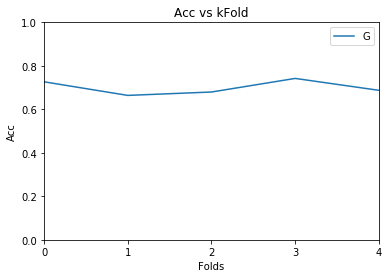

In [33]:
graphic_data([0,1,2,3,4],data,("GRU w2v50"),'Acc vs kFold', 'Folds', 'Acc',0,0,4,1)

#### Parte Validación: variando valor de units, w2v50, GRU

In [34]:
acc_final_w2v50 = []
score_final_w2v50 = []
history_final_w2v50 = []
models_w2v50 = []
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)
score_final_w2v50,acc_final_w2v50,history_final_w2v50,models_w2v50 = perform_final_validation(Xw2v50, Yw2v50,
                                                                                X_1w2v50, Y_1w2v50, w2v50_emb_size,
                                                                                              units_final,epochs,0)

########################
## UNIT SIZE  8
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 8)                 1416      
_________________________________________________________________
dropout_26 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_26 (Activation)   (None, 4)                 0         
Total params: 1,452
Trainable params: 1,452
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
640/640 [==============================] - 1s 2ms/step - loss: 1.4167 - accuracy: 0.2469
Epoch 2/200
640/640 [==============================] - 0s 321us/step - loss: 1.4098 - accuracy: 0.2438
Epoc

640/640 [==============================] - 0s 666us/step - loss: 1.0909 - accuracy: 0.4625
Epoch 72/200
640/640 [==============================] - 0s 284us/step - loss: 1.0719 - accuracy: 0.5078
Epoch 73/200
640/640 [==============================] - 0s 733us/step - loss: 1.0729 - accuracy: 0.5063
Epoch 74/200
640/640 [==============================] - 0s 344us/step - loss: 1.0487 - accuracy: 0.5219
Epoch 75/200
640/640 [==============================] - 1s 1ms/step - loss: 1.0324 - accuracy: 0.5391
Epoch 76/200
640/640 [==============================] - 1s 817us/step - loss: 1.0314 - accuracy: 0.5250
Epoch 77/200
640/640 [==============================] - 0s 646us/step - loss: 1.0337 - accuracy: 0.5125
Epoch 78/200
640/640 [==============================] - 0s 502us/step - loss: 1.0248 - accuracy: 0.5250
Epoch 79/200
640/640 [==============================] - 0s 269us/step - loss: 1.0271 - accuracy: 0.5281
Epoch 80/200
640/640 [==============================] - 0s 342us/step - loss: 1

640/640 [==============================] - 0s 357us/step - loss: 1.2912 - accuracy: 0.3750
Epoch 19/200
640/640 [==============================] - 0s 336us/step - loss: 1.2759 - accuracy: 0.3828
Epoch 20/200
640/640 [==============================] - 0s 323us/step - loss: 1.2784 - accuracy: 0.3969
Epoch 21/200
640/640 [==============================] - 0s 357us/step - loss: 1.2712 - accuracy: 0.3922
Epoch 22/200
640/640 [==============================] - 0s 476us/step - loss: 1.2642 - accuracy: 0.3922
Epoch 23/200
640/640 [==============================] - 0s 362us/step - loss: 1.2515 - accuracy: 0.4078
Epoch 24/200
640/640 [==============================] - 0s 425us/step - loss: 1.2444 - accuracy: 0.4187
Epoch 25/200
640/640 [==============================] - 0s 334us/step - loss: 1.2415 - accuracy: 0.4234
Epoch 26/200
640/640 [==============================] - 0s 345us/step - loss: 1.2275 - accuracy: 0.4250
Epoch 27/200
640/640 [==============================] - 0s 289us/step - loss:

640/640 [==============================] - 0s 330us/step - loss: 0.2993 - accuracy: 0.9141
Epoch 175/200
640/640 [==============================] - 0s 348us/step - loss: 0.3021 - accuracy: 0.9125
Epoch 176/200
640/640 [==============================] - 0s 374us/step - loss: 0.3156 - accuracy: 0.9172
Epoch 177/200
640/640 [==============================] - 0s 688us/step - loss: 0.2961 - accuracy: 0.9281
Epoch 178/200
640/640 [==============================] - 0s 354us/step - loss: 0.2958 - accuracy: 0.9234
Epoch 179/200
640/640 [==============================] - 0s 377us/step - loss: 0.2838 - accuracy: 0.9234
Epoch 180/200
640/640 [==============================] - 0s 328us/step - loss: 0.2764 - accuracy: 0.9219
Epoch 181/200
640/640 [==============================] - 0s 395us/step - loss: 0.3024 - accuracy: 0.9187
Epoch 182/200
640/640 [==============================] - 0s 504us/step - loss: 0.3101 - accuracy: 0.9203
Epoch 183/200
640/640 [==============================] - 0s 289us/ste

640/640 [==============================] - 0s 427us/step - loss: 0.0795 - accuracy: 0.9797
Epoch 122/200
640/640 [==============================] - 0s 407us/step - loss: 0.0842 - accuracy: 0.9828
Epoch 123/200
640/640 [==============================] - 0s 435us/step - loss: 0.0798 - accuracy: 0.9891
Epoch 124/200
640/640 [==============================] - 0s 470us/step - loss: 0.0839 - accuracy: 0.9844
Epoch 125/200
640/640 [==============================] - 0s 503us/step - loss: 0.0930 - accuracy: 0.9781
Epoch 126/200
640/640 [==============================] - 0s 552us/step - loss: 0.1040 - accuracy: 0.9797
Epoch 127/200
640/640 [==============================] - 0s 418us/step - loss: 0.1123 - accuracy: 0.9703
Epoch 128/200
640/640 [==============================] - 0s 542us/step - loss: 0.1055 - accuracy: 0.9812
Epoch 129/200
640/640 [==============================] - 0s 406us/step - loss: 0.0889 - accuracy: 0.9781
Epoch 130/200
640/640 [==============================] - 0s 550us/ste

640/640 [==============================] - 1s 793us/step - loss: 0.1342 - accuracy: 0.9641
Epoch 69/200
640/640 [==============================] - 0s 740us/step - loss: 0.1204 - accuracy: 0.9672
Epoch 70/200
640/640 [==============================] - 0s 527us/step - loss: 0.0981 - accuracy: 0.9688
Epoch 71/200
640/640 [==============================] - 0s 715us/step - loss: 0.0980 - accuracy: 0.9719
Epoch 72/200
640/640 [==============================] - 0s 637us/step - loss: 0.1029 - accuracy: 0.9734
Epoch 73/200
640/640 [==============================] - 0s 610us/step - loss: 0.0780 - accuracy: 0.9766
Epoch 74/200
640/640 [==============================] - 0s 664us/step - loss: 0.0773 - accuracy: 0.9812
Epoch 75/200
640/640 [==============================] - 0s 636us/step - loss: 0.0746 - accuracy: 0.9828
Epoch 76/200
640/640 [==============================] - 0s 646us/step - loss: 0.0649 - accuracy: 0.9844
Epoch 77/200
640/640 [==============================] - 1s 817us/step - loss:

640/640 [==============================] - 1s 1ms/step - loss: 0.6883 - accuracy: 0.6953
Epoch 16/200
640/640 [==============================] - 1s 1ms/step - loss: 0.6334 - accuracy: 0.7141
Epoch 17/200
640/640 [==============================] - 1s 1ms/step - loss: 0.6088 - accuracy: 0.7391
Epoch 18/200
640/640 [==============================] - 1s 1ms/step - loss: 0.5765 - accuracy: 0.7625
Epoch 19/200
640/640 [==============================] - 1s 1ms/step - loss: 0.5566 - accuracy: 0.7750
Epoch 20/200
640/640 [==============================] - 1s 1ms/step - loss: 0.5289 - accuracy: 0.8016
Epoch 21/200
640/640 [==============================] - 1s 1ms/step - loss: 0.4848 - accuracy: 0.8047
Epoch 22/200
640/640 [==============================] - 1s 1ms/step - loss: 0.4570 - accuracy: 0.8281
Epoch 23/200
640/640 [==============================] - 1s 1ms/step - loss: 0.4416 - accuracy: 0.8375
Epoch 24/200
640/640 [==============================] - 1s 1ms/step - loss: 0.4395 - accuracy: 

640/640 [==============================] - 1s 2ms/step - loss: 2.0731e-04 - accuracy: 1.0000
Epoch 171/200
640/640 [==============================] - 1s 1ms/step - loss: 1.8985e-04 - accuracy: 1.0000
Epoch 172/200
640/640 [==============================] - 1s 1ms/step - loss: 1.8463e-04 - accuracy: 1.0000
Epoch 173/200
640/640 [==============================] - 1s 1ms/step - loss: 2.2986e-04 - accuracy: 1.0000
Epoch 174/200
640/640 [==============================] - 1s 1ms/step - loss: 2.1407e-04 - accuracy: 1.0000
Epoch 175/200
640/640 [==============================] - 1s 1ms/step - loss: 2.1766e-04 - accuracy: 1.0000
Epoch 176/200
640/640 [==============================] - 1s 1ms/step - loss: 1.9754e-04 - accuracy: 1.0000
Epoch 177/200
640/640 [==============================] - 1s 1ms/step - loss: 2.1075e-04 - accuracy: 1.0000
Epoch 178/200
640/640 [==============================] - 1s 2ms/step - loss: 1.7417e-04 - accuracy: 1.0000
Epoch 179/200
640/640 [============================

640/640 [==============================] - 1s 1ms/step - loss: 0.0367 - accuracy: 0.9922
Epoch 120/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0223 - accuracy: 0.9953
Epoch 121/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0185 - accuracy: 0.9969
Epoch 122/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0149 - accuracy: 0.9969
Epoch 123/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0182 - accuracy: 0.9984
Epoch 124/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0145 - accuracy: 0.9984
Epoch 125/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0156 - accuracy: 0.9984
Epoch 126/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0100 - accuracy: 0.9984
Epoch 127/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0197 - accuracy: 0.9953
Epoch 128/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0151 - a

#### Parte  Gráficos: variando valor de units, w2v50, LSTM

In [35]:
#Preparando los datos para graficar
data_final_acc_w2v50 = []
data_final_loss_w2v50 = []


for i in np.arange(0,len(units_final)):
    data_final_acc_w2v50.append(history_final_w2v50[i].history['accuracy'])

for i in np.arange(0,len(units_final)):
    data_final_loss_w2v50.append(history_final_w2v50[i].history['loss'])
   

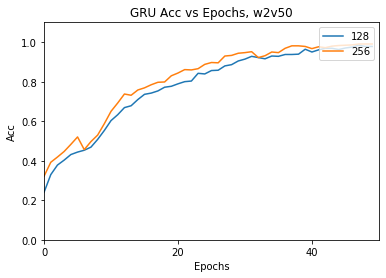

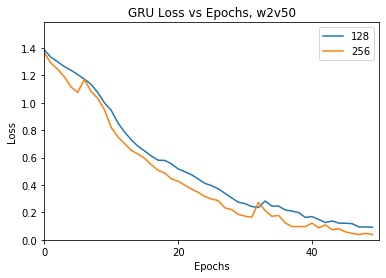

In [36]:
##Gráfico de Accuracy
graphic_data(np.arange(0,epochs,20),data_final_acc_w2v50,units_final,'GRU Acc vs Epochs, w2v50', 'Epochs', 'Acc',0,0,epochs,1+0.1)

##Gráfico de Loss 
max_loss_w2v50 = 0
for i in np.arange(0,len(data_final_loss_w2v50)):
    if(max(data_final_loss_w2v50[i]) > max_loss_w2v50):
        max_loss_w2v50 = max(data_final_loss_w2v50[i])
graphic_data(np.arange(0,epochs,20),data_final_loss_w2v50,units_final,'GRU Loss vs Epochs, w2v50', 'Epochs', 'Loss',
             0,0,epochs,max_loss_w2v50+0.2)

### Predicción: Modelo w2v50, LSTM

In [37]:
def predict_all_models(X_real, Y_real, models):
    j = 0
    all_predict = []
    counter_true =  collections.Counter(Y_real.argmax(1))
    for i in units_final:
        print("##### Predict, Units ", i,"#####")
        Y_predict_i=models[j].predict(X_real)
        counter_pred_i = collections.Counter(Y_predict_i.argmax(1))
        all_predict.append(Y_predict_i)
        print("predict: ",list(counter_pred_i.values()))
        print("Real   : ",list(counter_true.values()))
        j = j + 1
    return all_predict

In [38]:
all_predict_w2v50 = []
all_predict_w2v50 = predict_all_models(Xw2v50_full,Yw2v50_full,models_w2v50)

##### Predict, Units  128 #####
predict:  [186, 196, 171, 200]
Real   :  [188, 180, 180, 205]
##### Predict, Units  256 #####
predict:  [184, 184, 202, 183]
Real   :  [188, 180, 180, 205]


In [39]:
i = 0
for j in units_final:
    print("Units:", j, " - RMSE GRU w2v50:  ",mean_squared_error(Yw2v50_full, all_predict_w2v50[i])) #Y_true, Y_predict
    i = i + 1

Units: 128  - RMSE GRU w2v50:   0.023150997
Units: 256  - RMSE GRU w2v50:   0.02316517


#### Matriz Confusión: w2v50

Confusion matrix, without normalization
Confusion matrix, without normalization


<Figure size 360x360 with 0 Axes>

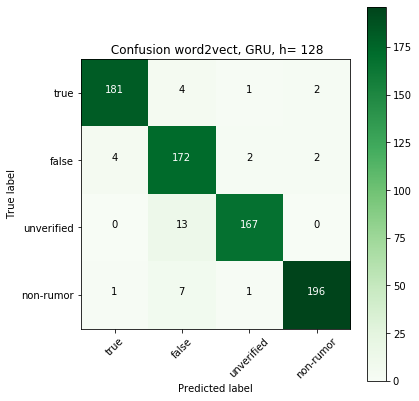

<Figure size 360x360 with 0 Axes>

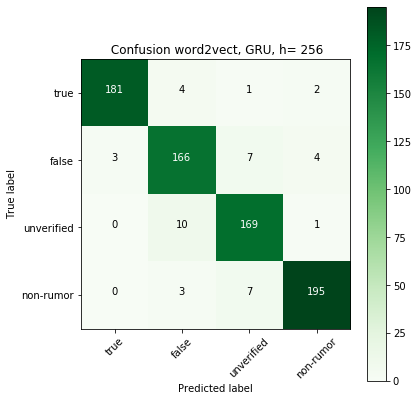

In [40]:
j = 0
for i in units_final:
    plot_conf_matrix(Yw2v50_full, all_predict_w2v50[j]," Confusion word2vect, GRU, h= " + str(i))
    j = j +1